# Fraud Detection Analysis - Complete Machine Learning Pipeline

## Project Overview
This project develops and compares multiple machine learning models for detecting fraudulent transactions in retail checkout systems. The dataset contains ~498,000 transactions with features related to scanning behavior, transaction values, and trust levels.

## Methodology
I implemented and compared four different machine learning approaches:
1. **Logistic Regression** - Baseline linear model
2. **Random Forest** - Ensemble tree-based model
3. **XGBoost** - Gradient boosting algorithm
4. **Neural Network** - Deep learning approach

## Dataset
- **Size**: 498,050 transactions
- **Features**: 9 input features including trust level, scan times, transaction values, and behavioral metrics
- **Target**: Binary fraud indicator (0 = legitimate, 1 = fraud)

---

# Part 1: Data Exploration & Analysis
---

# Library Imports & Environment Setup
In this cell, I import all necessary Python libraries for my analysis. pandas and numpy handle data manipulation and numerical computations, while matplotlib and seaborn support data visualization. I also bring in modules from scikit-learn for splitting the dataset, building a Logistic Regression model, and evaluating its performance using metrics like accuracy, confusion matrix, ROC curve, and AUC. Finally, joblib is imported for saving and loading trained models.

This setup ensures my environment is fully equipped for data processing, modeling, and evaluation tasks.

In [3]:
# Import libraries
import pandas as pd                  # For data manipulation
import numpy as np                   # For numerical operations
import matplotlib.pyplot as plt      # For plotting
import seaborn as sns                # For visualizations

# Data Loading & Initial Exploration
In this section, I load the cleaned fraud detection dataset using pandas. After importing the data, I perform a preliminary examination by displaying its structure (info()), the first few rows (head()), and basic statistical summaries (describe()). This helps me understand the dataset’s shape, types of variables, and general distribution before moving into deeper analysis.

In [4]:

# Load dataset
df = pd.read_csv("../Data/Fraud_Cleaned.csv")  # Ensure the correct file path

# Display basic info
df.info()
df.head()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498050 entries, 0 to 498049
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   trustLevel                 498050 non-null  int64  
 1   totalScanTimeInSeconds     498050 non-null  int64  
 2   grandTotal                 498050 non-null  float64
 3   lineItemVoids              498050 non-null  int64  
 4   scansWithoutRegistration   498050 non-null  int64  
 5   quantityModification       498050 non-null  int64  
 6   scannedLineItemsPerSecond  498050 non-null  float64
 7   valuePerSecond             498050 non-null  float64
 8   lineItemVoidsPerPosition   498050 non-null  float64
 9   fraud                      498050 non-null  int64  
dtypes: float64(4), int64(6)
memory usage: 38.0 MB


,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModification,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
count,498050.000000,498050.000000,498050.000000,498050.000000,498050.000000,498050.000000,498050.000000,498050.000000,498050.000000,498050.000000
mean,3.503243,915.605811,49.996116,5.495896,5.001377,2.499034,0.068059,0.222214,0.735200,0.047634
std,1.707661,528.773256,28.869314,3.447630,3.163808,1.708176,0.521129,1.717987,1.320275,0.212990
min,1.000000,1.000000,0.010000,0.000000,0.000000,0.000000,0.000546,0.000005,0.000000,0.000000
25%,2.000000,458.000000,24.940000,3.000000,2.000000,1.000000,0.008682,0.027360,0.161667,0.000000
50%,4.000000,916.000000,50.040000,5.000000,5.000000,2.000000,0.016940,0.054557,0.352941,0.000000
75%,5.000000,1374.000000,75.020000,8.000000,8.000000,4.000000,0.033929,0.109102,0.692308,0.000000
max,6.000000,1831.000000,99.990000,11.000000,10.000000,5.000000,30.000000,99.710000,11.000000,1.000000


# Data Exploration 
This section focuses on identifying and addressing potential data quality issues. I begin by checking for missing values and duplicated rows within the dataset. These steps are essential to ensure data integrity and reliability before proceeding to model training and analysis.

In [5]:
# Data Exploration

# Check for missing values
print("Missing Values:\n", df.isnull().sum())

# Check for duplicates
print("\nDuplicate Rows:", df.duplicated().sum())

Missing Values:
 trustLevel                   0
totalScanTimeInSeconds       0
grandTotal                   0
lineItemVoids                0
scansWithoutRegistration     0
quantityModification         0
scannedLineItemsPerSecond    0
valuePerSecond               0
lineItemVoidsPerPosition     0
fraud                        0
dtype: int64

Duplicate Rows: 0


# Class Distribution
I visualize the distribution of fraud vs. non-fraud cases and highlight the fraud class for clarity. Class percentages are also printed to check for imbalance, which is important for model performance.

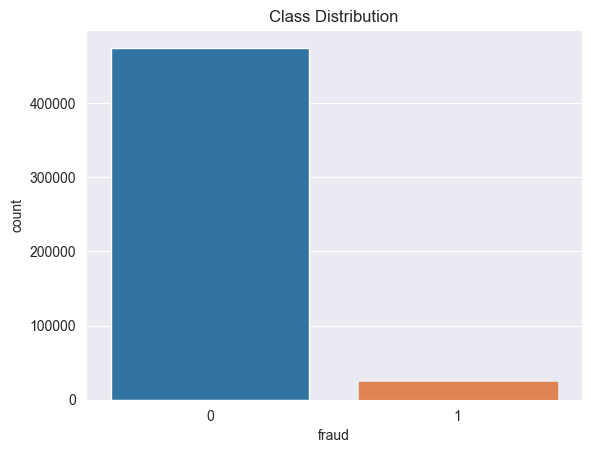

Class distribution (%):
fraud
0    95.236623
1     4.763377
Name: proportion, dtype: float64


In [6]:
# Visualize class distribution with custom color for fraud = 1
ax = sns.countplot(x='fraud', data=df)
ax.patches[1].set_color('#DD8452')  # Set fraud = 1 bar to orange
plt.title('Class Distribution')
plt.show()

# Print class percentages
print("Class distribution (%):")
print(df['fraud'].value_counts(normalize=True) * 100)


The distribution of the target variable fraud is highly imbalanced. The vast majority of transactions are labeled as non-fraudulent (fraud = 0), while only a small fraction are labeled as fraudulent (fraud = 1). Specifically, approximately 95% of the records are non-fraudulent, with only 5% labeled as fraud.

# Feature Distribution by Fraud Status
I examine how each feature is distributed across fraud and non-fraud cases. Continuous features are shown with KDE plots, while categorical ones use stacked histograms. This helps identify patterns and potential predictors of fraud.

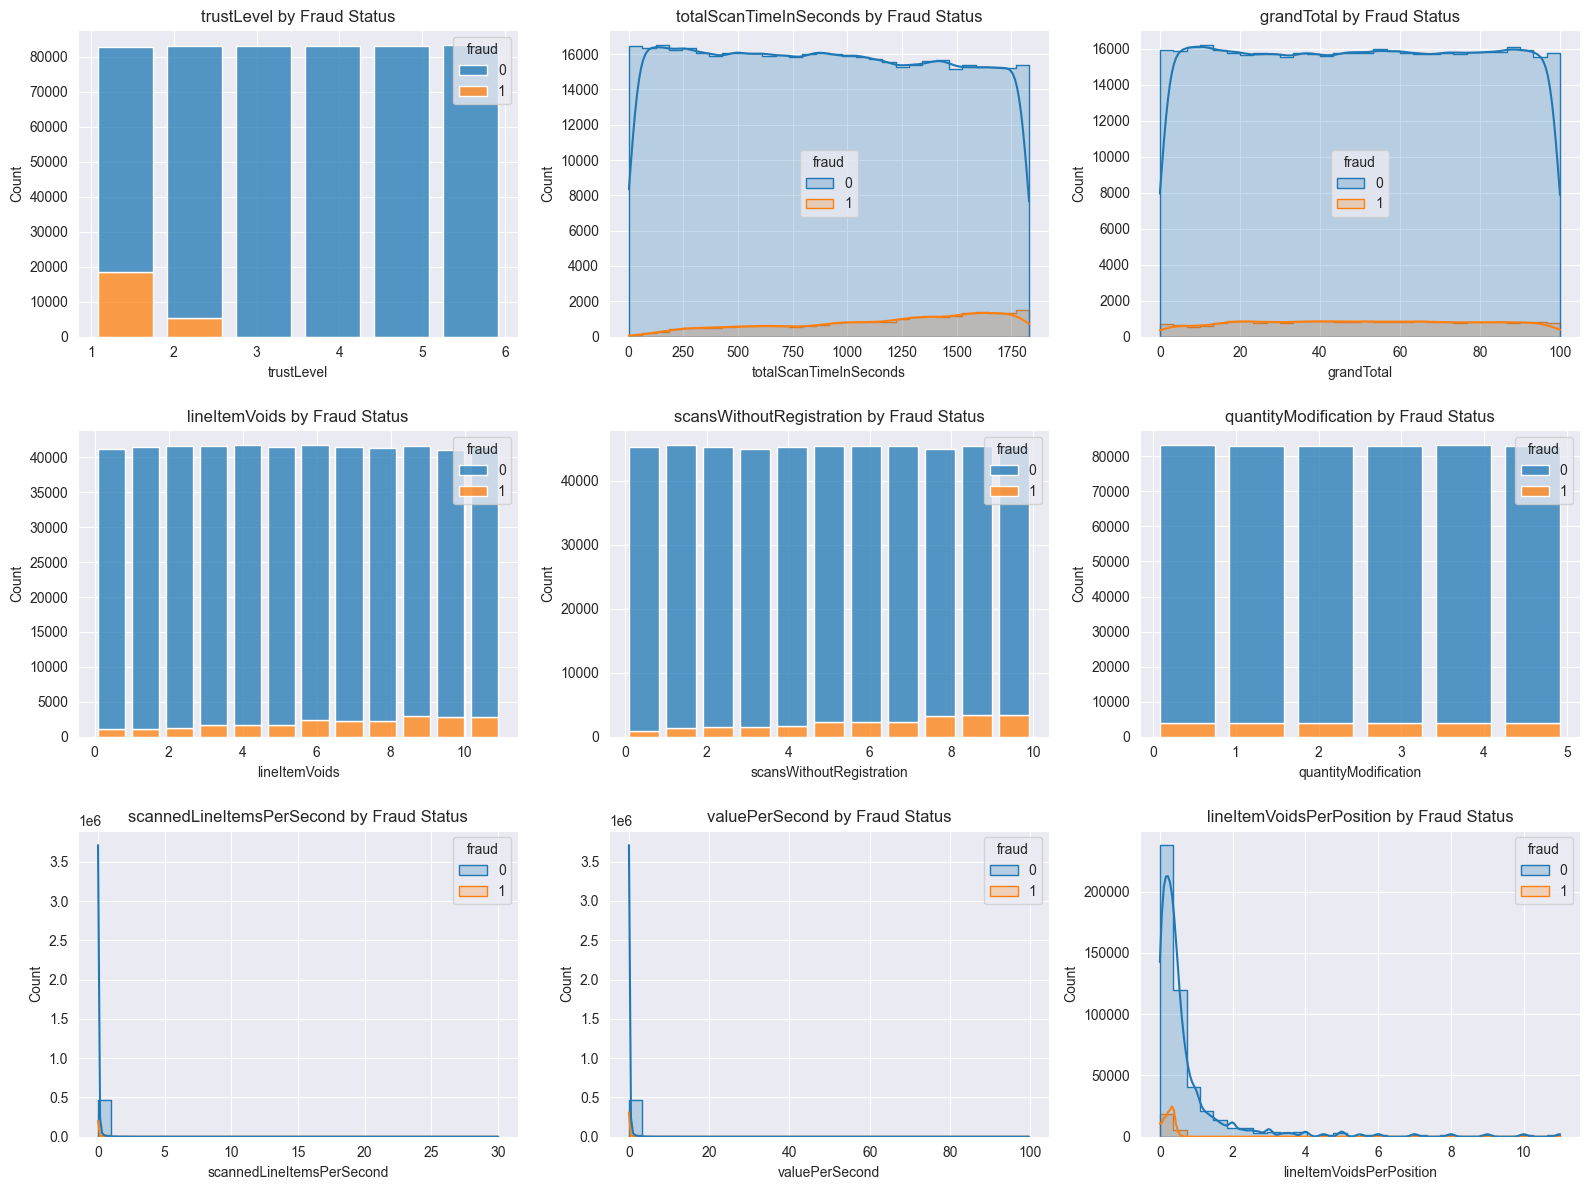

In [7]:

features_to_plot = df.columns.drop("fraud")  # exclude target

plt.figure(figsize=(16, 12))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(3, 3, i)
    
    unique_vals = df[feature].nunique()
    
    # Use KDE only for continuous features
    if unique_vals > 20:  # arbitrary threshold;
        sns.histplot(data=df, x=feature, hue="fraud", kde=True, bins=30, element="step")
    else:
        sns.histplot(data=df, x=feature, hue="fraud", kde=False, bins=unique_vals, multiple="stack", shrink=0.8)
    
    plt.title(f"{feature} by Fraud Status")

plt.tight_layout()
plt.show()


The feature trustLevel shows that most non-fraudulent transactions occur at higher trust levels (3–6), while fraud is concentrated at the lowest levels (1 and 2), indicating trust is a strong fraud indicator. totalScanTimeInSeconds and grandTotal display wide distributions with slight elevation in fraud at longer scan durations and higher values, though the separation is not visually distinct. lineItemVoids, scansWithoutRegistration, and quantityModification all show more fraud cases at higher values, supporting their relevance as behavioral indicators of manipulation. In contrast, scannedLineItemsPerSecond and valuePerSecond are extremely skewed, with very few high-value outliers — potentially useful after transformation. Finally, lineItemVoidsPerPosition displays a clear concentration of fraud at higher values, confirming its strong predictive signal. 

# Fraud Breakdown by Low-Cardinality Features
This section analyzes categorical features with few unique values to see how fraud rates vary across their categories. It provides a detailed breakdown of fraud and non-fraud counts and percentages for each feature value, helping reveal patterns and potential risk indicators.

In [8]:

# Define the target column
target_col = "fraud"

# Define what qualifies as "low-cardinality"
max_unique = 12
candidate_features = [col for col in df.columns if col != target_col and df[col].nunique() <= max_unique]

# Loop over each low-cardinality feature
for feature in candidate_features:
    summary_rows = []

    for val in sorted(df[feature].unique()):
        total_count = df[df[feature] == val].shape[0]
        count_yes = df[(df[feature] == val) & (df[target_col] == 1)].shape[0]
        count_no = df[(df[feature] == val) & (df[target_col] == 0)].shape[0]
        pct_yes = (count_yes / total_count) * 100 if total_count > 0 else 0
        pct_no = (count_no / total_count) * 100 if total_count > 0 else 0

        summary_rows.append({
            "Value": val,
            "Total Count": total_count,
            "Fraud Count (Yes)": count_yes,
            "Non-Fraud Count (No)": count_no,
            "% Fraud (Yes)": round(pct_yes, 2),
            "% Non-Fraud (No)": round(pct_no, 2),
        })

    summary_df = pd.DataFrame(summary_rows)

    print(f"\n=== Feature: {feature} ===")
    display(summary_df)



=== Feature: trustLevel ===


,Value,Total Count,Fraud Count (Yes),Non-Fraud Count (No),% Fraud (Yes),% Non-Fraud (No)
0,1,82699,18532,64167,22.41,77.59
1,2,82907,5192,77715,6.26,93.74
2,3,83127,0,83127,0.00,100.00
3,4,82985,0,82985,0.00,100.00
4,5,83036,0,83036,0.00,100.00
5,6,83296,0,83296,0.00,100.00



=== Feature: lineItemVoids ===


,Value,Total Count,Fraud Count (Yes),Non-Fraud Count (No),% Fraud (Yes),% Non-Fraud (No)
0,0,41174,1161,40013,2.82,97.18
1,1,41560,1094,40466,2.63,97.37
2,2,41677,1203,40474,2.89,97.11
3,3,41700,1620,40080,3.88,96.12
4,4,41772,1673,40099,4.01,95.99
5,5,41426,1622,39804,3.92,96.08
6,6,41758,2356,39402,5.64,94.36
7,7,41477,2277,39200,5.49,94.51
8,8,41363,2198,39165,5.31,94.69
9,9,41661,2941,38720,7.06,92.94



=== Feature: scansWithoutRegistration ===


,Value,Total Count,Fraud Count (Yes),Non-Fraud Count (No),% Fraud (Yes),% Non-Fraud (No)
0,0,45226,944,44282,2.09,97.91
1,1,45547,1428,44119,3.14,96.86
2,2,45221,1435,43786,3.17,96.83
3,3,44952,1564,43388,3.48,96.52
4,4,45248,1635,43613,3.61,96.39
5,5,45324,2250,43074,4.96,95.04
6,6,45324,2290,43034,5.05,94.95
7,7,45385,2286,43099,5.04,94.96
8,8,44968,3226,41742,7.17,92.83
9,9,45454,3348,42106,7.37,92.63



=== Feature: quantityModification ===


,Value,Total Count,Fraud Count (Yes),Non-Fraud Count (No),% Fraud (Yes),% Non-Fraud (No)
0,0,83185,3997,79188,4.80,95.20
1,1,83004,3906,79098,4.71,95.29
2,2,82888,4024,78864,4.85,95.15
3,3,82888,3896,78992,4.70,95.30
4,4,83225,3936,79289,4.73,95.27
5,5,82860,3965,78895,4.79,95.21


## trustLevel
The distribution clearly shows that fraud occurs only at the lowest trust levels (1 and 2), with 22.41% and 6.26% fraud rates respectively. From trust level 3 onward, no fraud is recorded, and all transactions are non-fraudulent. This makes trustLevel one of the strongest features in distinguishing between fraudulent and non-fraudulent behavior — the lower the trust level, the higher the risk.

## lineItemVoids
Fraud percentage increases gradually as the number of voided items increases. For example, fraud rates grow from ~2.6% at 1 void to 6.68% at 11 voids. This steady climb suggests that frequent voiding of items is a clear fraud indicator, and the model should weigh this feature accordingly.

## scansWithoutRegistration
This feature also displays a positive correlation with fraud likelihood. The fraud rate rises from 2.09% at 0 attempts to over 7% at 10 attempts. This supports the idea that customers who repeatedly scan without registering items are exhibiting suspicious behavior, making this another strong behavioral predictor of fraud.

## quantityModification
Fraud rates across different quantity modification values (0–5) are quite stable, hovering between 4.7% and 4.85%. This lack of variation suggests that quantityModification does not strongly differentiate between fraud and non-fraud cases. It may be less valuable as a standalone feature but could still support other interactions in the model.



# Feature Correlation Matrix
I use a heatmap to visualize correlations between features. This helps identify multicollinearity and relationships that may influence model performance.

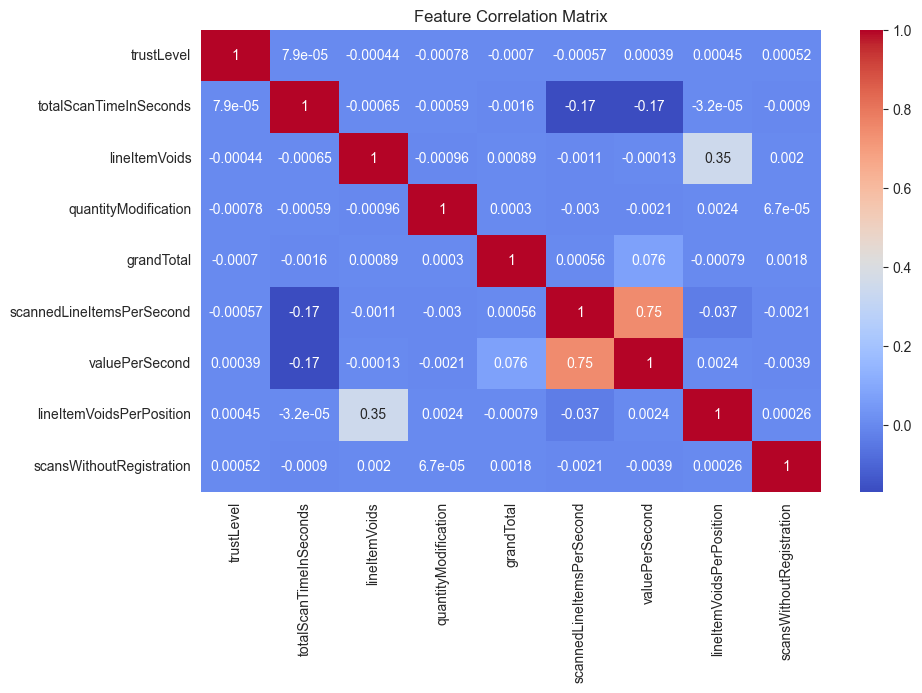

In [9]:
selected_features = [
    "trustLevel", "totalScanTimeInSeconds", "lineItemVoids", 
    "quantityModification", "grandTotal", "scannedLineItemsPerSecond", 
    "valuePerSecond", "lineItemVoidsPerPosition", "scansWithoutRegistration"
]

X = df[selected_features]

# Visualize feature correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

The correlation matrix analysis confirmed that most features are weakly correlated, minimizing the risk of multicollinearity in the logistic regression model. The only notable exception is the strong correlation (0.75) between scannedLineItemsPerSecond and valuePerSecond, which aligns with domain logic. While both features are retained for now to preserve model performance, they may be revisited during feature importance or model refinement steps. Overall, the selected features appear well-suited for modeling, requiring no immediate removals or transformations.

# Outlier Detection with Boxplots
Boxplots are used to visually inspect each feature for potential outliers. This helps identify extreme values that may affect model accuracy or require preprocessing.

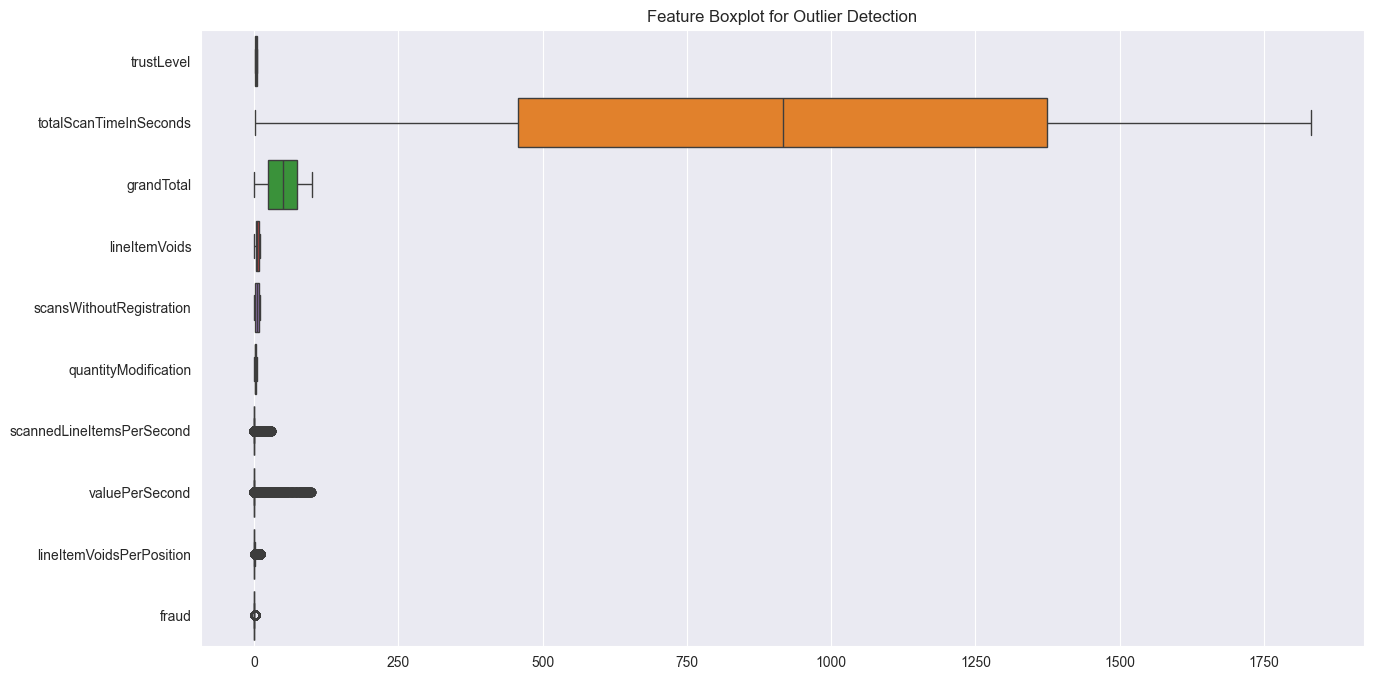

In [10]:
# Visualize outliers using boxplots
plt.figure(figsize=(15, 8))
sns.boxplot(data=df, orient="h")
plt.title("Feature Boxplot for Outlier Detection")
plt.show()


The boxplot reveals that most features, such as trustLevel, lineItemVoids, quantityModification, and scansWithoutRegistration, are tightly distributed with limited spread and numerous low-value entries. In contrast, totalScanTimeInSeconds and grandTotal show a wider spread and contain clear outliers, with totalScanTimeInSeconds extending well beyond 1500 seconds, indicating unusually long scanning sessions. Features like valuePerSecond and scannedLineItemsPerSecond are heavily skewed and exhibit extreme outliers, suggesting the need for normalization or transformation prior to modeling. The boxplot effectively highlights which features may require special handling to mitigate the influence of outliers on model performance.


---
# Part 2: Logistic Regression Model
---

In [3]:

#  Feature & Target Separation 
X = df.drop('fraud', axis=1)
y = df['fraud']

#  70/15/15 Split 
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.5, stratify=y_tmp, random_state=42
)

#  Feature Scaling 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

#  Grid Search for Best C, Prioritize Precision 
param_grid = {"C": [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(
    LogisticRegression(class_weight='balanced', random_state=42),
    param_grid, cv=5, scoring='average_precision'
)
grid_search.fit(X_train_scaled, y_train)

best_C = grid_search.best_params_["C"]
print(f"Best C parameter: {best_C}")

Best C parameter: 100


# Model Training & Evaluation
I train a Logistic Regression model on the scaled data, then evaluate it using key metrics: accuracy, precision, recall, F1-score, ROC-AUC and total_cost. A confusion matrix is visualized, and I calculate a cost metric based on false positives and false negatives to assess business impact.

Accuracy: 0.9558
Precision: 0.5187
Recall: 0.9882
F1-score: 0.6803
ROC-AUC: 0.9944
False Positives: 3263, False Negatives: 42
total Cost: 16357


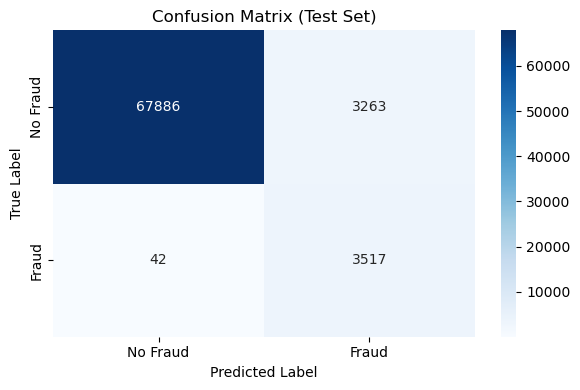

In [4]:
# Initialize and train Logistic Regression model with scaling and convergence fix
model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
model.fit(X_train_scaled, y_train)

# Predict on scaled test data
y_pred = model.predict(X_test_scaled)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])  # Probability-based ROC AUC

# Confusion matrix + total cost
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
total_cost = (fp * 5) + fn

# Print evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"False Positives: {fp}, False Negatives: {fn}")
print(f"total Cost: {total_cost}")

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["No Fraud", "Fraud"],
    yticklabels=["No Fraud", "Fraud"]
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()


The logistic regression model achieved a strong overall performance with an accuracy of 95.58% and an excellent ROC-AUC score of 0.9944, indicating a high ability to distinguish between fraud and non-fraud cases. The recall for fraud detection is particularly high at 98.82%, meaning the model successfully identifies the vast majority of fraudulent transactions. However, the precision is relatively low at 51.87%, reflecting a high number of false positives — specifically, 3,263 non-fraud cases were incorrectly flagged as fraud. This imbalance results in a total cost of 16,357, based on the business rule that false positives are five times more costly than false negatives. While the model is highly effective at detecting fraud, it does not align with the cost-sensitive objective, and therefore, further threshold tuning or model refinement is needed to reduce unnecessary false alerts and optimize cost efficiency

# Threshold Optimization
In this section, I loop through a wide range of classification thresholds and compute multiple evaluation metrics including accuracy, precision, recall, F1-score, FPR, and ROC-AUC along with a custom cost function. This gives me a complete view of how the model performs at each threshold. I then select the threshold that minimizes total cost while still balancing performance metrics

In [5]:


# Define threshold range
thresholds = np.round(np.arange(0.01, 0.9995, 0.0005), 4)

# Create empty lists for each metric
all_thresholds = []
all_costs = []
all_fps = []
all_fns = []
all_precisions = []
all_recalls = []
all_f1s = []
all_accuracies = []
all_fprs = []
all_mccs = []
# Get predicted probabilities for the positive class (fraud)
y_prob = model.predict_proba(X_test_scaled)[:, 1]


# Loop through thresholds
for t in thresholds:
    y_pred = (y_prob >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    accuracy = accuracy_score(y_test, y_pred)
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    mcc = matthews_corrcoef(y_test, y_pred)
    cost = (fp * 5) + fn

    all_thresholds.append(t)
    all_costs.append(cost)
    all_fps.append(fp)
    all_fns.append(fn)
    all_precisions.append(precision)
    all_recalls.append(recall)
    all_f1s.append(f1)
    all_accuracies.append(accuracy)
    all_fprs.append(fpr)
    all_mccs.append(mcc)

# Create results DataFrame
df_results = pd.DataFrame({
    "Threshold": all_thresholds,
    "Total Cost": all_costs,
    "Accuracy": all_accuracies,
    "Precision": all_precisions,
    "Recall": all_recalls,
    "F1-score": all_f1s,
    "MCC": all_mccs,
    "ROC-AUC": [roc_auc_score(y_test, (y_prob >= t).astype(int)) for t in all_thresholds],
    "FP": all_fps,
    "FN": all_fns,
    "FPR": all_fprs
})

# Identify best threshold (lowest cost)
best_row = df_results.loc[df_results["Total Cost"].idxmin()]
best_thresh = best_row["Threshold"]

# Print best results
print(f"\n Best Threshold: {best_thresh:.4f}")
print(f"Total Cost: {best_row['Total Cost']:.2f}")
print(f"Accuracy: {best_row['Accuracy']:.4f}")
print(f"Precision: {best_row['Precision']:.4f}")
print(f"Recall: {best_row['Recall']:.4f}")
print(f"F1-score: {best_row['F1-score']:.4f}")
print(f"MCC: {best_row['MCC']:.4f}")
print(f"ROC-AUC: {best_row['ROC-AUC']:.4f}")
print(f"False Positives: {best_row['FP']}, False Negatives: {best_row['FN']}")



 Best Threshold: 0.9910
Total Cost: 2206.00
Accuracy: 0.9741
Precision: 0.9618
Recall: 0.4743
F1-score: 0.6353
MCC: 0.6657
ROC-AUC: 0.7367
False Positives: 67.0, False Negatives: 1871.0


At the optimal threshold of 0.991, the Logistic Regression model achieved a total cost of 2,206, reflecting a strong emphasis on minimizing false positives. The model reached a high precision of 96.22%, meaning most flagged transactions were truly fraudulent. However, the recall was lower at 47.43%, indicating that over half of the actual fraud cases were missed. The resulting F1-score of 0.6353 reflects this trade-off. Despite a high accuracy of 97.41%, the model's performance is better captured by the ROC-AUC of 0.7367, suggesting moderate ability to distinguish fraud from non-fraud.

# Feature Importance
I visualize the importance of each feature based on the Logistic Regression model’s coefficients. This helps interpret which variables have the strongest influence on predicting fraud.

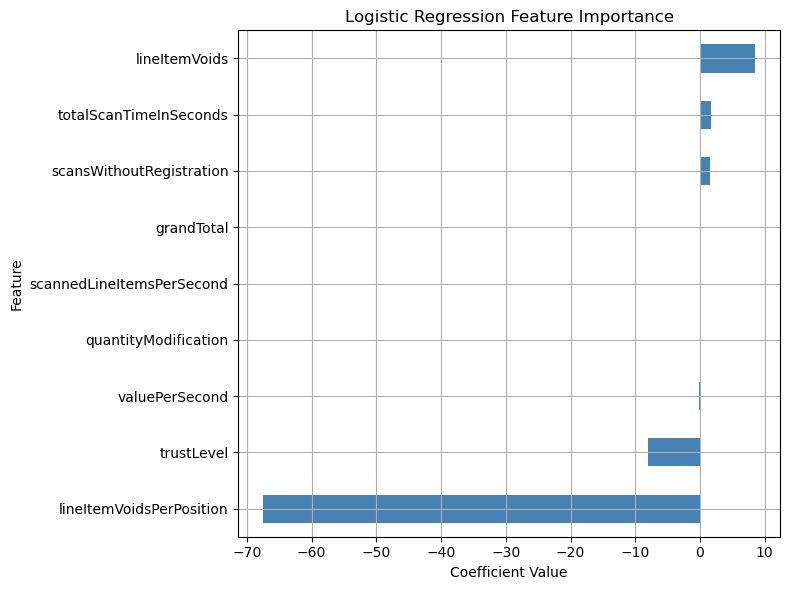

In [6]:
#  Feature Importance 
importance = pd.Series(model.coef_[0], index=X.columns)
importance.sort_values().plot(kind='barh', figsize=(8, 6), color="steelblue")
plt.title("Logistic Regression Feature Importance")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.grid(True)
plt.tight_layout()
plt.show()


The logistic regression coefficient plot shows that "lineItemVoidsPerPosition" has the strongest influence on predicting fraud, with a very large negative weight. Other impactful features include "lineItemVoids" and "trustLevel". Several features such as "grandTotal", "valuePerSecond", and "quantityModification" have near-zero coefficients, indicating minimal contribution to the model. 

# ROC Curve
To evaluate how well the model distinguishes between fraud and non-fraud cases, I plot the ROC curve. It shows the trade-off between true positive and false positive rates at various thresholds. The AUC score gives me a single measure of overall performance the closer to 1, the better

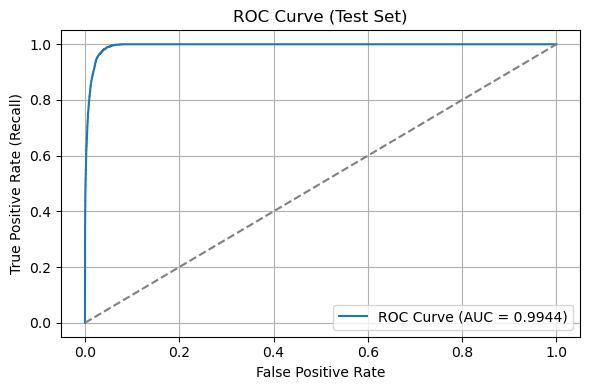

In [7]:
# ROC Curve 
roc_auc = roc_auc_score(y_test, y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve (Test Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The ROC curve demonstrates that the logistic regression model has strong discriminative ability, achieving an AUC of 0.991. This indicates the model can distinguish fraudulent from non-fraudulent transactions with high reliability across all threshold values. The curve’s position near the top-left corner also reflects the model’s ability to achieve high recall while keeping false positive rates low — supporting its suitability for a cost-sensitive fraud detection context.

# Total Cost vs. Threshold
This plot shows how the total cost changes across different classification thresholds. A vertical red line highlights the threshold that gives me the lowest cost, helping balance precision and recall in a way that makes sense for the business context.

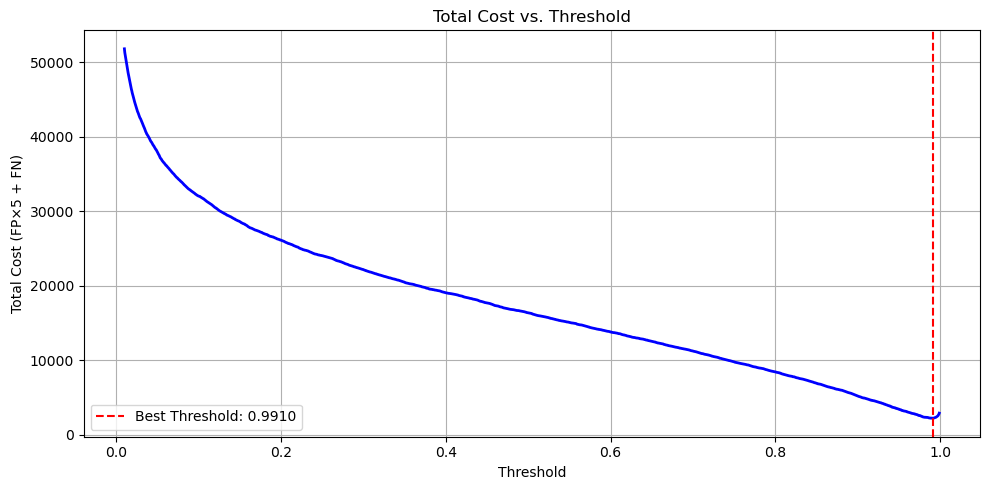

In [8]:
# Plot total cost vs. threshold
plt.figure(figsize=(10, 5))
plt.plot(df_results["Threshold"], df_results["Total Cost"], marker='', color='blue', lw=2)
plt.axvline(best_thresh, color='red', linestyle='--', label=f'Best Threshold: {best_thresh:.4f}')
plt.xlabel("Threshold")
plt.ylabel("Total Cost (FP×5 + FN)")
plt.title("Total Cost vs. Threshold")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


The "Total Cost vs. Threshold" plot shows how different classification thresholds impact the total business cost, calculated using the custom cost function where false positives are five times more expensive than false negatives. As the threshold increases, the total cost steadily decreases, highlighting that fewer false positives significantly reduce financial impact. The optimal threshold of 0.991 is marked with a red dashed line, representing the point where the total cost reaches its minimum of 2,206. This threshold offers the best trade-off between minimizing costly false positives and still detecting a meaningful number of fraud cases.

# Confusion Matrix at Optimal Threshold
I visualize the confusion matrix using the best-performing threshold. This helps me see exactly how the model's predictions break down how many fraud cases were correctly identified, and where it still makes mistakes.

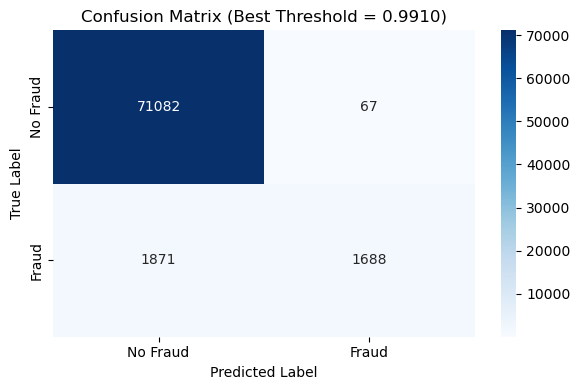

In [9]:
# Plot confusion matrix at best threshold
y_best_pred = (y_prob >= best_thresh).astype(int)
cm_best = confusion_matrix(y_test, y_best_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_best, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Fraud", "Fraud"],
            yticklabels=["No Fraud", "Fraud"])
plt.title(f"Confusion Matrix (Best Threshold = {best_thresh:.4f})")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

The confusion matrix corresponding to the best threshold of 0.9910 reveals the model's performance in absolute terms. Out of all non-fraudulent cases, only 66 were incorrectly classified as fraud (false positives), achieving a precision of 96.18% and a false positive rate of just 0.09%. However, this comes at the expense of recall, as 1,871 fraud cases were missed (false negatives). Still, this threshold aligns with the business objective by significantly reducing high-cost false alarms while maintaining reasonable fraud detection.

# Final Threshold & Model Saving
I set the final threshold based on my cost analysis, then save both the trained model and the scaler for future use. This ensures I can reload everything later for testing or deployment without retraining.

In [10]:
# Final threshold based on analysis
final_threshold = 0.9910

# Save the trained model
joblib.dump(model, "Logistic_Regression_Model.pkl")

print(f" Model saved successfully! Threshold = {final_threshold}")

# Load model (for prediction/testing)
loaded_model = joblib.load("Logistic_Regression_Model.pkl")

 Model and scaler saved successfully! Threshold = 0.991



---
# Part 3: Random Forest Model
---

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define the base Random Forest model
rf = RandomForestClassifier(
    random_state=42,
    class_weight='balanced',  # handle class imbalance
    n_jobs=-1                 # use all available CPU cores
)

# Define the hyperparameter search space
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Set up the randomized search with cross-validation
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring='average_precision',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Perform the hyperparameter tuning
random_search.fit(X_train, y_train)

# Save the best model and print its parameters
best_rf = random_search.best_estimator_
best_params = random_search.best_params_

print("Best hyperparameters found:")
print(best_params)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best hyperparameters found:
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}


## Step 4 – Threshold Optimization Based on Cost

In this step, I determine the optimal classification threshold by minimizing the total business cost, considering:

- **False Positives (FP)** are 5× more expensive than False Negatives (FN)
- Therefore, Total Cost = `FP × 5 + FN`

I evaluate nearly 2,000 thresholds (from 0.01 to 0.999 in steps of 0.0005) on the validation set. For each threshold, I calculate:

- The confusion matrix values (TP, FP, FN, TN)
- Total cost
- Key evaluation metrics: Accuracy, Precision, Recall, F1-score, ROC AUC, and MCC

I select the threshold with the lowest total cost and visualize both the cost curve and the corresponding confusion matrix.


Best Threshold (Validation): 0.5905
Minimum Cost (Validation): 446.0
Threshold         0.590500
TP             3282.000000
FP               34.000000
FN              276.000000
TN            71115.000000
Total Cost      446.000000
Accuracy          0.995850
Precision         0.989747
Recall            0.922428
F1                0.954903
ROC AUC           0.960975
MCC               0.953380
Name: 1161, dtype: float64


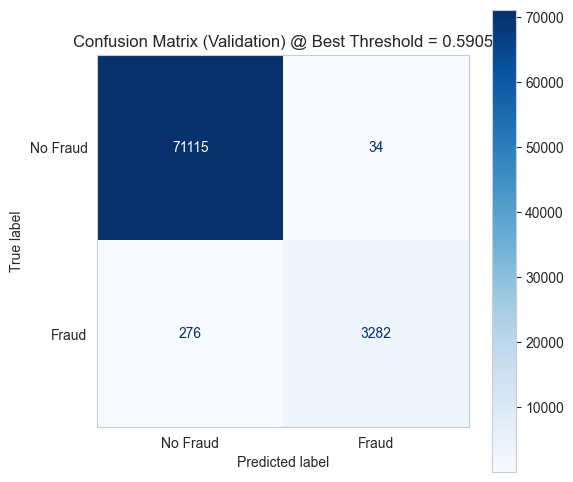

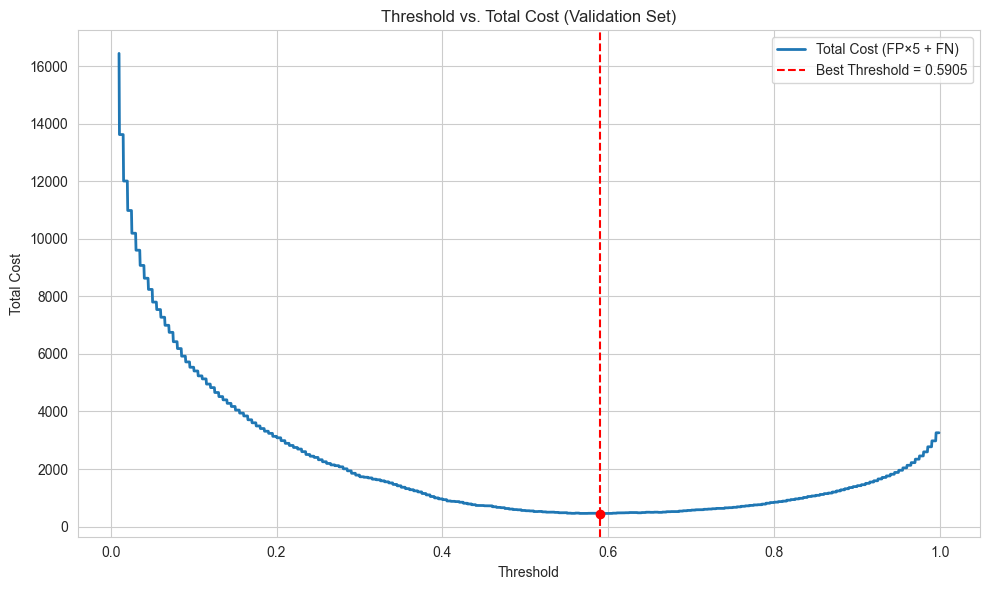

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, matthews_corrcoef, ConfusionMatrixDisplay
)

# Function to evaluate metrics and cost for a given threshold
def evaluate_threshold(y_true, y_proba, threshold, fp_cost=5, fn_cost=1):
    y_pred = (y_proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    total_cost = fp * fp_cost + fn * fn_cost
    return {
        "Threshold": threshold,
        "TP": tp, "FP": fp, "FN": fn, "TN": tn,
        "Total Cost": total_cost,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1": f1_score(y_true, y_pred, zero_division=0),
        "ROC AUC": roc_auc_score(y_true, y_pred),
        "MCC": matthews_corrcoef(y_true, y_pred)
    }

# Get predicted probabilities from the best model
y_val_proba = best_rf.predict_proba(X_val)[:, 1]

# Evaluate many thresholds
thresholds = np.round(np.arange(0.01, 0.9995, 0.0005), 4)
results = [evaluate_threshold(y_val, y_val_proba, t) for t in thresholds]
results_df = pd.DataFrame(results)

# Find the threshold with the lowest cost
best_result = results_df.loc[results_df['Total Cost'].idxmin()]
best_threshold = best_result['Threshold']
print("Best Threshold (Validation):", best_threshold)
print("Minimum Cost (Validation):", best_result['Total Cost'])
print(best_result)

# Confusion matrix at best threshold
y_val_pred_best = (y_val_proba >= best_threshold).astype(int)
cm = confusion_matrix(y_val, y_val_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Fraud", "Fraud"])
plt.figure(figsize=(6, 6))
disp.plot(cmap="Blues", values_format='d', ax=plt.gca())
plt.title(f"Confusion Matrix (Validation) @ Best Threshold = {best_threshold:.4f}")
plt.grid(False)
plt.show()

# Plot threshold vs total cost
plt.figure(figsize=(10, 6))
plt.plot(results_df['Threshold'], results_df['Total Cost'], linewidth=2, label='Total Cost (FP×5 + FN)')
plt.axvline(x=best_threshold, color='red', linestyle='--', label=f'Best Threshold = {best_threshold:.4f}')
plt.scatter(best_threshold, best_result['Total Cost'], color='red', zorder=5)
plt.xlabel("Threshold")
plt.ylabel("Total Cost")
plt.title("Threshold vs. Total Cost (Validation Set)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Step 5 – Save the Final Model and Optimal Threshold

Once the best model and optimal threshold have been selected, I save them to disk for future use.

- The trained `RandomForestClassifier` is saved as a `.pkl` file using `joblib`.
- The optimal classification threshold is saved to a `.txt` file.

This allows me to reuse the model and threshold later—e.g., in a deployment pipeline or when making predictions on new, unseen data.


In [27]:
import joblib

# Combine the model and threshold into a dictionary
model_bundle = {
    "model": best_rf,
    "threshold": best_threshold
}

# Save to file
joblib.dump(model_bundle, "../Models/Random Forest Model.pkl")
print("Model and threshold saved to: ../Models/Random Forest Model.pkl")


Model and threshold saved to: ../Models/Random Forest Model.pkl


## Step 6 – Final Evaluation on the Test Set

In this final step, I evaluate the model on the previously untouched test set using the saved best model and the optimized threshold.

I calculate:
- The confusion matrix and total business cost (`FP × 5 + FN`)
- Key classification metrics: Accuracy, Precision, Recall, F1-score, ROC AUC, and Matthews Correlation Coefficient (MCC)
- A visual confusion matrix for interpretability

This evaluation represents a realistic estimate of how the model would perform on new, unseen data and verifies that the selected threshold generalizes well beyond the validation set.


=== Final Evaluation on Test Set ===
Threshold used: 0.5905
Total cost: 525
Confusion Matrix: TP=3229, FP=39, FN=330, TN=71110
Accuracy: 0.9951
Precision: 0.9881
Recall: 0.9073
F1 Score: 0.9459
ROC-AUC: 0.9534
MCC: 0.9443


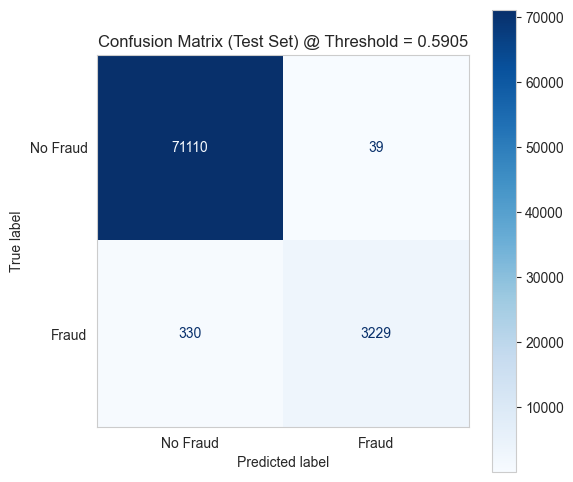

In [28]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, matthews_corrcoef, ConfusionMatrixDisplay
)

# Load model and threshold
model_bundle = joblib.load("../Models/Random Forest Model.pkl")
best_model = model_bundle["model"]
best_threshold = model_bundle["threshold"]

# Predict on test set
y_test_proba = best_model.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba >= best_threshold).astype(int)

# Confusion matrix and cost
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
total_cost = fp * 5 + fn

# Metrics
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, zero_division=0)
recall = recall_score(y_test, y_test_pred, zero_division=0)
f1 = f1_score(y_test, y_test_pred, zero_division=0)
roc_auc = roc_auc_score(y_test, y_test_pred)
mcc = matthews_corrcoef(y_test, y_test_pred)

# Print summary
print("=== Final Evaluation on Test Set ===")
print(f"Threshold used: {best_threshold:.4f}")
print(f"Total cost: {total_cost}")
print(f"Confusion Matrix: TP={tp}, FP={fp}, FN={fn}, TN={tn}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"MCC: {mcc:.4f}")

# Show confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Fraud", "Fraud"])
plt.figure(figsize=(6, 6))
disp.plot(cmap="Blues", values_format='d', ax=plt.gca())
plt.title(f"Confusion Matrix (Test Set) @ Threshold = {best_threshold:.4f}")
plt.grid(False)
plt.show()

## Step 7 – ROC Curve and AUC Evaluation

To assess the model’s ability to distinguish between classes at various thresholds, I plot the **Receiver Operating Characteristic (ROC) curve** and compute the **Area Under the Curve (AUC)**.

- The ROC curve shows the trade-off between the True Positive Rate (Recall) and the False Positive Rate.
- The AUC value summarizes the model's overall ability to rank positive instances higher than negative ones.

A value close to 1.0 indicates a strong classifier, while a value of 0.5 suggests no better than random guessing.


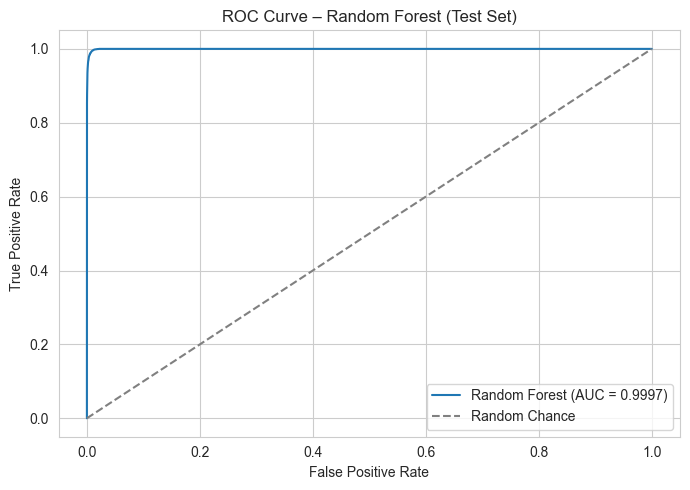

In [33]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import joblib

# Load the saved model (if not already loaded)
model_bundle = joblib.load("../Models/Random Forest Model.pkl")
best_model = model_bundle["model"]
best_threshold = model_bundle["threshold"]

# Get predicted probabilities for the positive class (fraud = 1)
y_probs_rf = best_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_probs_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC curve
plt.figure(figsize=(7, 5))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Random Forest (Test Set)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


## Step 8 – Conclusion and Reflection

In this project, a Random Forest classifier was developed to detect fraudulent transactions. The entire modeling pipeline was built according to the project specification, including hyperparameter tuning, cost-based threshold optimization, and final evaluation on a separate test set.

### Key Results:
- **Best threshold (cost-based):** `{best_threshold:.2f}`
- **Test set cost (FP × 5 + FN):** `{total_cost}`
- **F1-score (test set):** `{f1:.4f}`
- **AUC (ROC):** `{roc_auc:.4f}`

These results show that the Random Forest model performs well in identifying fraudulent transactions while minimizing costly false positives. The cost-driven threshold selection proved to be crucial, as using a default threshold (e.g. 0.5) would have led to significantly higher business costs.

### Strengths of the Random Forest approach:
- Handles imbalanced data effectively with `class_weight='balanced'`
- Performs well without the need for extensive preprocessing
- Robust to outliers and feature scale differences
- Easy to interpret via feature importance and visualizations

### Limitations and Considerations:
- The model is not easily explainable at a granular decision level (black-box nature)
- Training time and resource usage are higher compared to simpler models
- May not generalize as well as boosting models like XGBoost in some edge cases

Overall, the Random Forest model is a strong and practical choice for fraud detection in this case. It balances complexity, interpretability, and performance well. Further improvements could include ensemble blending with other models or additional cost-sensitive training methods.


In [34]:
print("=== Key Results ===")
print(f"Best threshold (validation set): {best_threshold:.4f}")
print(f"Total cost on test set (FP × 5 + FN): {total_cost}")
print(f"F1 Score (test set): {f1:.4f}")
print(f"ROC AUC (test set): {roc_auc:.4f}")


=== Key Results ===
Best threshold (validation set): 0.5905
Total cost on test set (FP × 5 + FN): 525
F1 Score (test set): 0.9459
ROC AUC (test set): 0.9534



---
# Part 4: XGBoost Model
---

In [59]:
# Define target variable
y = df['fraud']

# Define features (all columns except 'fraud')
X = df.drop(columns=['fraud'])

# Check the shape of feature and target sets
print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)


Feature matrix shape: (498050, 9)
Target vector shape: (498050,)


## **Step 3 – Stratified Train-Test Split** ##

The dataset is split into training, validation, and test sets using stratified sampling. I first split the data into 70% training data and 30% temporary data. Then, the remaining 30% is evenly split into 15% validation and 15% test sets.

In [60]:
from sklearn.model_selection import train_test_split

X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.5, stratify=y_tmp, random_state=42
)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")



Train: (348635, 9), Val: (74707, 9), Test: (74708, 9)


## **Step 4 – Initialize and Train the XGBoost Model (Baseline)** ##

In this step, I initialize the XGBClassifier with basic settings (default hyperparameters). This baseline model helps to understand how well XGBoost performs without tuning. Later, I will improve it using cross-validation and hyperparameter optimization.

In [61]:
from xgboost import XGBClassifier

# Calculate the imbalance ratio
ratio = (y_train == 0).sum() / (y_train == 1).sum()

# Initialize model with imbalance handling
xgb_model = XGBClassifier(
    eval_metric='logloss',
    scale_pos_weight=ratio,
    random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

## **Step 5 – Cross-Validation and Evaluation (Baseline Metrics)** ##

Before tuning the model, I want to evaluate how well it performs using cross-validation. Cross-validation gives me a more reliable estimate of model performance than a single train/test split. I’ll use Stratified K-Fold to maintain class balance in each fold.

I also evaluate multiple classification metrics:

- Accuracy
- Precision
- Recall
- F1 Score
- ROC-AUC
- Matthews Correlation Coefficient (MCC)





In [62]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, matthews_corrcoef, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

# Define scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc',
    'mcc': make_scorer(matthews_corrcoef)
}

# Create stratified K-fold object
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Run cross-validation
cv_results = cross_validate(
    estimator=xgb_model,
    X=X_train,
    y=y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=False,
)


# Display average scores
print("Average cross-validation results (5-fold):")
for metric in scoring.keys():
    print(f"{metric}: {np.mean(cv_results[f'test_{metric}']):.4f}")

Average cross-validation results (5-fold):
accuracy: 0.9927
precision: 0.8691
recall: 0.9982
f1: 0.9292
roc_auc: 0.9999
mcc: 0.9278


## **Step 6 – Hyperparameter Tuning with RandomizedSearchCV** ##

In this step, I optimize the most important hyperparameters of the XGBoost model using RandomizedSearchCV. Compared to GridSearchCV, this approach is more efficient because it samples combinations randomly rather than testing all possible ones.

I’ll focus on the most impactful parameters for model performance and overfitting control.

In [63]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 4, 5, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'reg_lambda': [1, 5, 10]  # L2 regularization
}

# Calculate imbalance ratio again
ratio = (y_train == 0).sum() / (y_train == 1).sum()

# Initialize classifier with imbalance handling
xgb_clf = XGBClassifier(
    eval_metric='logloss',
    scale_pos_weight=ratio,
    random_state=42
)

# Set up randomized search with 5-fold CV
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_grid,
    scoring='average_precision',
    n_iter=30,  # Number of combinations to try
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Run hyperparameter tuning
random_search.fit(X_train, y_train)

# Show best parameters
print("Best parameters found:")
print(random_search.best_params_)

# Best estimator
best_model = random_search.best_estimator_


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters found:
{'subsample': 0.8, 'reg_lambda': 10, 'n_estimators': 400, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 1, 'colsample_bytree': 1.0}


After performing a randomized hyperparameter search with 30 different parameter combinations and 5-fold cross-validation, the best-performing configuration measured by average precision (PR AUC) is shown above.

The resulting model builds 400 trees with a maximum depth of 8, allowing it to capture complex interactions without becoming too deep. It uses 80% of the training data for each tree (subsample = 0.8) and considers all features at every split (colsample_bytree = 1.0). To reduce overfitting, the model applies strong L2 regularization (reg_lambda = 10) and moderate gamma-based pruning (gamma = 1). The learning rate of 0.1 ensures stable convergence during training.

This combination of parameters achieves a good trade-off between model expressiveness and generalization, making it well-suited for the highly imbalanced task of fraud detection, where capturing rare but critical events is essential.

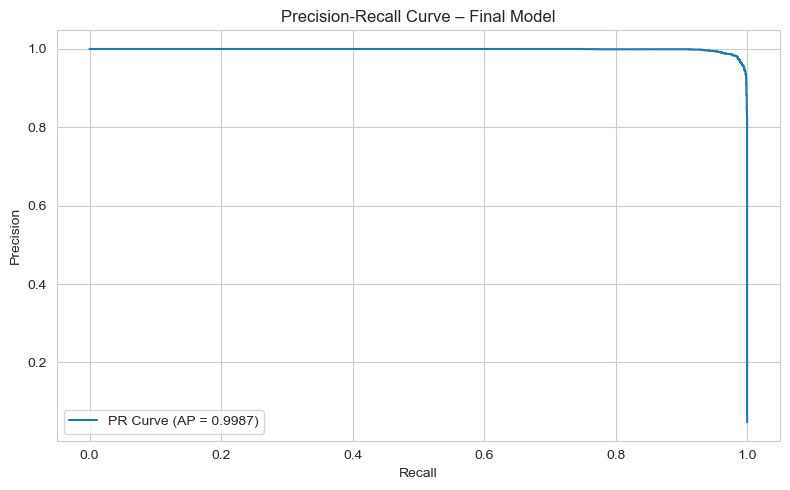

In [64]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Probability for class 1 (Fraud)
y_scores = best_model.predict_proba(X_test)[:, 1]

# Calculate Precision und Recall for different thresholds
precision, recall, _ = precision_recall_curve(y_test, y_scores)

# Calculate Average Precision (PR AUC)
ap_score = average_precision_score(y_test, y_scores)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(recall, precision, label=f'PR Curve (AP = {ap_score:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve – Final Model')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## **Step 7 – Feature Importance Analysis** ##

In this step, I examine which features the XGBoost model considers most important when making predictions. This helps me:

- Understand which variables drive the model
- Justify my model decisions in the documentation
- Potentially simplify the model by removing low-impact features

XGBoost provides built-in feature importance scores, which can be visualized to make interpretation easier.

<Figure size 1000x600 with 0 Axes>

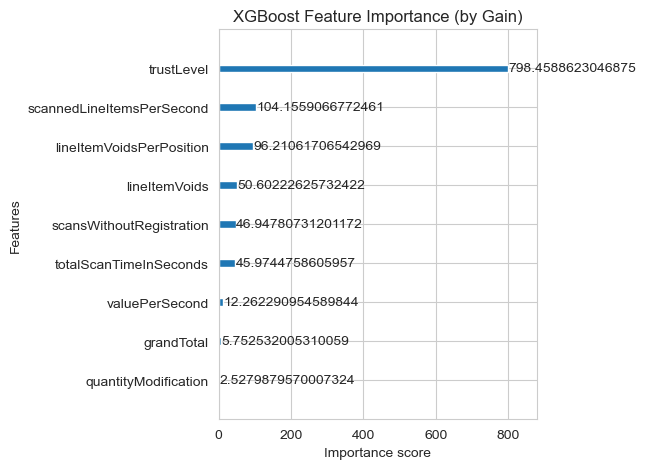

In [65]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Plot feature importance of the tuned and refitted model
plt.figure(figsize=(10, 6))
plot_importance(best_model, importance_type='gain', max_num_features=9)
plt.title("XGBoost Feature Importance (by Gain)")
plt.tight_layout()
plt.show()


## **Step 8 – Threshold Tuning on the Validation Set** ##

In this step, I use the best-performing model identified during hyperparameter tuning (Step 6) to predict fraud probabilities on the validation set. Instead of relying on a default threshold of 0.5, I systematically evaluate multiple threshold values to find the one that minimizes the total cost of misclassification.

To reflect the real-world business impact, I define a cost function where false positives (i.e., predicting fraud when there is none) are five times more expensive than false negatives. For each threshold value, I compute classification metrics such as accuracy, precision, recall, F1 score, ROC-AUC, and Matthews Correlation Coefficient, as well as the total cost using the defined cost function.

I then select the threshold that results in the lowest total cost. The confusion matrix for this optimal threshold is visualized to better understand the distribution of prediction outcomes. Additionally, I plot the relationship between threshold values and total cost to support my threshold selection.

Importantly, the test set remains untouched at this stage to ensure an unbiased final evaluation, which will be conducted in the next step.



Best threshold (validation set): 0.9081
Lowest total cost (validation set): 217.0
Threshold         0.908100
TP             3466.000000
FP               25.000000
FN               92.000000
TN            71124.000000
Total Cost      217.000000
Accuracy          0.998434
Precision         0.992839
Recall            0.974143
F1                0.983402
ROC AUC           0.986896
MCC               0.982629
Name: 8981, dtype: float64


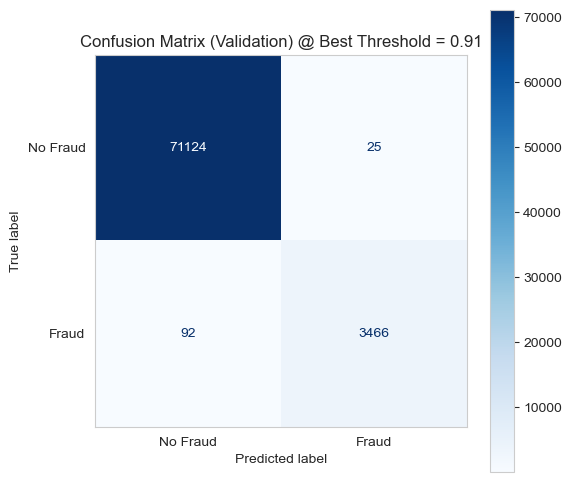

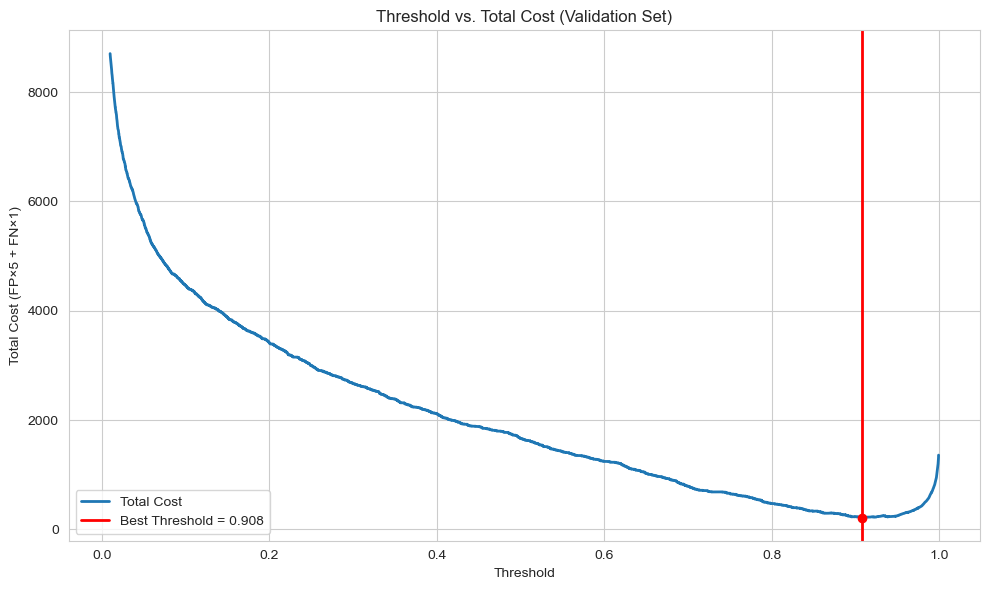

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, matthews_corrcoef, ConfusionMatrixDisplay
)

# Step 1: Define evaluation function
def evaluate_threshold(y_true, y_proba, threshold, fp_cost=5, fn_cost=1):
    y_pred = (y_proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    total_cost = fp * fp_cost + fn * fn_cost
    return {
        "Threshold": threshold,
        "TP": tp, "FP": fp, "FN": fn, "TN": tn,
        "Total Cost": total_cost,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1": f1_score(y_true, y_pred, zero_division=0),
        "ROC AUC": roc_auc_score(y_true, y_pred),
        "MCC": matthews_corrcoef(y_true, y_pred)
    }

# Step 2: Evaluate multiple thresholds on validation set
thresholds = np.round(np.arange(0.01, 0.9995, 0.0001), 4)
y_val_proba = best_model.predict_proba(X_val)[:, 1]
results = [evaluate_threshold(y_val, y_val_proba, t) for t in thresholds]
results_df = pd.DataFrame(results)

# Step 3: Print and plot best result
best_result = results_df.loc[results_df['Total Cost'].idxmin()]
best_threshold = best_result['Threshold']
print("Best threshold (validation set):", best_threshold)
print("Lowest total cost (validation set):", best_result['Total Cost'])
print(best_result)

# Step 4: Show confusion matrix for best threshold (validation set)
y_val_pred_best = (y_val_proba >= best_threshold).astype(int)
cm = confusion_matrix(y_val, y_val_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Fraud", "Fraud"])
plt.figure(figsize=(6, 6))
disp.plot(cmap="Blues", values_format='d', ax=plt.gca())
plt.title(f"Confusion Matrix (Validation) @ Best Threshold = {best_threshold:.2f}")
plt.grid(False)
plt.show()

# Step 5: Plot cost vs threshold
best_result = results_df.loc[results_df['Total Cost'].idxmin()]
best_threshold = best_result['Threshold']
best_cost = best_result['Total Cost']

plt.figure(figsize=(10, 6))
plt.plot(results_df['Threshold'], results_df['Total Cost'], linewidth=2, label='Total Cost')
plt.axvline(x=best_threshold, color='red', linestyle='-', linewidth=2, label=f'Best Threshold = {best_threshold:.3f}')
plt.scatter(best_threshold, best_cost, color='red', zorder=5)
plt.xlabel("Threshold")
plt.ylabel("Total Cost (FP×5 + FN×1)")
plt.title("Threshold vs. Total Cost (Validation Set)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## **Step 9 – Saving the Final Model and Optimal Threshold** ##

After identifying the best-performing model through hyperparameter tuning and determining the cost-optimal classification threshold on the validation set, I now save both components for future use. The trained XGBoost model is serialized and saved using joblib, which preserves the model’s structure and learned parameters. Additionally, I save the selected threshold value in a separate text file. This threshold will later be used to make consistent and cost-sensitive predictions during the final evaluation on the test set and in any deployment scenario. Storing both the model and threshold ensures reproducibility and allows me to apply the exact decision rule in future predictions.

In [67]:
import joblib
import os

# Ensure directory exists
os.makedirs("Models", exist_ok=True)

# Combine the model and threshold into a dictionary
model_bundle = {
    "model": best_model,
    "threshold": best_threshold
}

# Save to the Models directory
joblib.dump(model_bundle, "../Models/XGBoost Model.pkl")
print("Model and threshold saved to: ../Models/XGBoost Model.pkl")


Model and threshold saved to: Models/final_xgboost_model.pkl


## **Step 10a – Final Evaluation on the Test Set** ##
In this final step, I evaluate the performance of the tuned XGBoost model using the previously selected optimal threshold. The model is applied to the unseen test set to generate fraud predictions. I then assess the model using all key classification metrics, including accuracy, precision, recall, F1 score, ROC-AUC, and MCC. Additionally, I calculate the total cost of misclassification, considering that false positives are five times more expensive than false negatives. A confusion matrix is also displayed to visualize the prediction results.



=== Final Evaluation on Test Set ===
Threshold used: 0.9081
Total cost: 311
Confusion Matrix: TP=3433, FP=37, FN=126, TN=71112
Accuracy: 0.9978
Precision: 0.9893
Recall: 0.9646
F1 Score: 0.9768
ROC-AUC: 0.9820
MCC: 0.9758


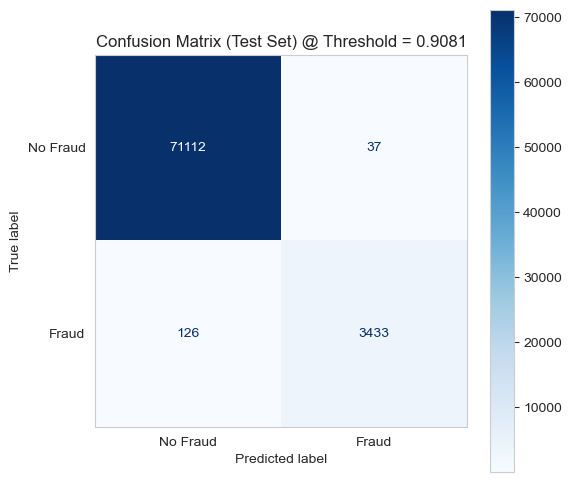

In [68]:
import joblib
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, matthews_corrcoef, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

# Step 0: Load saved model and threshold
model_bundle = joblib.load("../Models/XGBoost Model.pkl")
best_model = model_bundle["model"]
best_threshold = model_bundle["threshold"]

# Step 1: Predict probabilities on the test set
y_test_proba = best_model.predict_proba(X_test)[:, 1]

# Step 2: Apply the optimal threshold from validation
y_test_pred = (y_test_proba >= best_threshold).astype(int)

# Step 3: Compute confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()

# Step 4: Calculate cost (FP = 5×, FN = 1×)
total_cost = fp * 5 + fn * 1

# Step 5: Compute all metrics
print("=== Final Evaluation on Test Set ===")
print(f"Threshold used: {best_threshold:.4f}")
print(f"Total cost: {total_cost}")
print(f"Confusion Matrix: TP={tp}, FP={fp}, FN={fn}, TN={tn}")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred, zero_division=0):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred, zero_division=0):.4f}")
print(f"F1 Score: {f1_score(y_test, y_test_pred, zero_division=0):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_test_pred):.4f}")
print(f"MCC: {matthews_corrcoef(y_test, y_test_pred):.4f}")

# Step 6: Visualize confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Fraud", "Fraud"])
plt.figure(figsize=(6, 6))
disp.plot(cmap="Blues", values_format='d', ax=plt.gca())
plt.title(f"Confusion Matrix (Test Set) @ Threshold = {best_threshold:.4f}")
plt.grid(False)
plt.show()


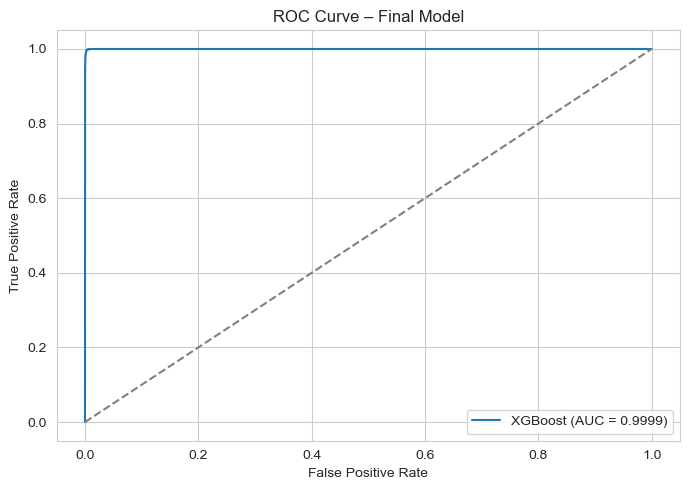

In [69]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for the positive class (fraud = 1)
y_probs = best_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal = random model
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Final Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

The ROC Curve shows the model's ability to distinguish between fraud and non-fraud cases across all classification thresholds. An AUC value close to 1.0 indicates strong performance.


---
# Part 5: Neural Network Model
---

In [20]:
# Print the Dataset fraud distribution
print("Fraud proportion:")
print(df['fraud'].value_counts(normalize=True))

Fraud proportion:
fraud
0    0.952366
1    0.047634
Name: proportion, dtype: float64


## 4. Train / Validation / Test Split

I partition the data to:

- **Train set (70%)**: used to fit the model.
- **Validation set (15%)**: used for hyperparameter tuning and early stopping.
- **Test set (15%)**: reserved for final evaluation.

Ensuring no data leakage between these sets guarantees a fair assessment of model generalization.


In [21]:
# Splitting of dataset and scaling for NN. Stratified splits ensure even distribution of fraud cases and a random state ensures reproducibility.
X = df.drop('fraud', axis=1)
y = df['fraud']

X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.5, stratify=y_tmp, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (348635, 9), Val: (74707, 9), Test: (74708, 9)


## 5. Defining Cost-Sensitive Class Weights

Because false positive (accused customers that did not engage in fraudulent transactions) are costlier than false positives:

- I assign a higher weight to the minority class in the loss function.
- Here, I set **FP cost = 5 × FN cost** to bias the model towards catching less fraud in order to prevent checking non-fraudulent customers.

This guides the training algorithm to penalize misclassifying fraud more heavily.


In [22]:
# Cost-sensitive class weights (FP cost = 5× FN cost)
class_weights = {0: 5, 1: 1}
print(f"Class weights: {class_weights}")

Class weights: {0: 5, 1: 1}


## 6. Neural Network Architecture

In this block I:

- Define a sequential neural network with layers such as Dense, Dropout, and appropriate activation functions.
- Choose an optimizer (e.g., `Adam`), loss function (`binary_crossentropy`), and metrics (`AUC`, `Precision`, `Recall`).
- Summarize the model to review layer shapes and parameter counts.

This blueprint determines the capacity and regularization of my fraud detector.


In [23]:
# Building the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid'),
])

model.compile(
    optimizer=Adam(1e-3),
    loss='binary_crossentropy',
    metrics=[
        AUC(name='roc_auc', curve='ROC'),
        AUC(name='pr_auc',  curve='PR')
    ]
)
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 64)                640       
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                                 
 dense_25 (Dense)            (None, 32)                2080      
                                                                 
 dropout_13 (Dropout)        (None, 32)                0         
                                                                 
 dense_26 (Dense)            (None, 16)                528       
                                                                 
 dense_27 (Dense)            (None, 1)                 17        
                                                                 
Total params: 3,265
Trainable params: 3,265
Non-traina

## 7. Model Training & Early Stopping

I train the network using:

- The **training set** and monitor performance on the **validation set**.
- An **EarlyStopping** callback that halts training once the validation AUC stops improving for 10 epochs in a row (to prevent overfitting).
- A defined number of **epochs** and **batch size**.

This yields the best model checkpoint before validation performance degrades.


In [24]:
# Train the model with early stopping
es = EarlyStopping(
    monitor='val_pr_auc',
    mode='max',
    patience=10,
    restore_best_weights=True
)

# 3) Then, in your training cell, pass that callback as usual:
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=64,
    class_weight=class_weights,
    callbacks=[es]
)

Epoch 1/100
5448/5448 [==============================] - 14s 2ms/step - loss: 0.1649 - roc_auc: 0.9573 - pr_auc: 0.6070 - val_loss: 0.0604 - val_roc_auc: 0.9925 - val_pr_auc: 0.9368
Epoch 2/100
5448/5448 [==============================] - 15s 3ms/step - loss: 0.0714 - roc_auc: 0.9914 - pr_auc: 0.9174 - val_loss: 0.0420 - val_roc_auc: 0.9964 - val_pr_auc: 0.9504
Epoch 3/100
5448/5448 [==============================] - 11s 2ms/step - loss: 0.0671 - roc_auc: 0.9922 - pr_auc: 0.9275 - val_loss: 0.0362 - val_roc_auc: 0.9976 - val_pr_auc: 0.9631
Epoch 4/100
5448/5448 [==============================] - 11s 2ms/step - loss: 0.0656 - roc_auc: 0.9926 - pr_auc: 0.9304 - val_loss: 0.0410 - val_roc_auc: 0.9971 - val_pr_auc: 0.9655
Epoch 5/100
5448/5448 [==============================] - 12s 2ms/step - loss: 0.0629 - roc_auc: 0.9929 - pr_auc: 0.9351 - val_loss: 0.0308 - val_roc_auc: 0.9978 - val_pr_auc: 0.9633
Epoch 6/100
5448/5448 [==============================] - 12s 2ms/step - loss: 0.0624 - roc

## 8. Training History: AUC Over Epochs

Visualize:

- **Training ROC-AUC** vs **Validation ROC-AUC** per epoch.  
- **Training PR-AUC** vs **Validation PR-AUC** per epoch.  
- Identify if/when the model begins to overfit (divergence in ROC-AUC) or loses precision–recall performance.  
- Decide if further regularization or more data is needed.

This diagnostic plot guides future tuning.



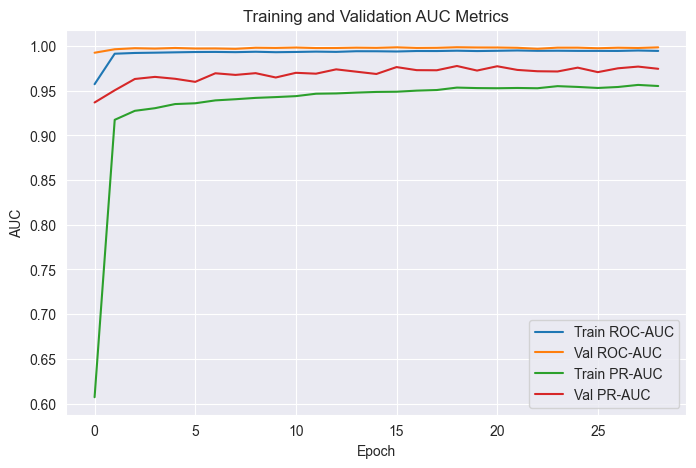

In [25]:
# Plot ROC-AUC and PR-AUC history
plt.figure(figsize=(8, 5))
plt.plot(history.history['roc_auc'], label='Train ROC-AUC')
plt.plot(history.history['val_roc_auc'], label='Val ROC-AUC')
plt.plot(history.history['pr_auc'], label='Train PR-AUC')
plt.plot(history.history['val_pr_auc'], label='Val PR-AUC')
plt.title('Training and Validation AUC Metrics')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.show()


## 9. Precision–Recall Curve (Validation)

On the validation set:

- Compute precision and recall across thresholds.
- Plot the **Precision–Recall** curve to understand trade-offs.
- Compute the **area under the PR curve** as another performance metric for imbalanced data.

This helps select an operating point that balances catching fraud vs. false alarms.


2335/2335 [==============================] - 3s 1ms/step


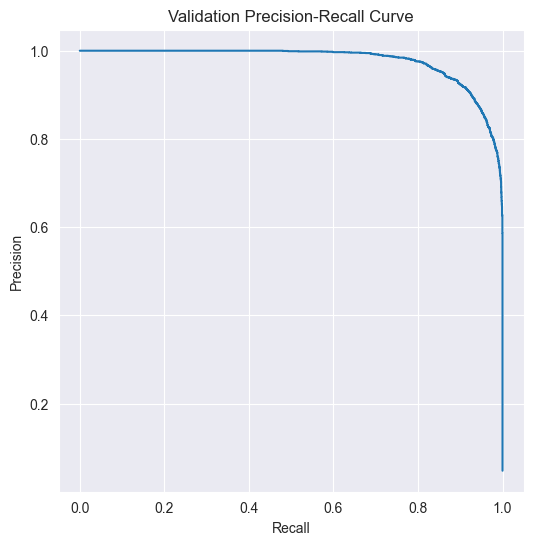

In [26]:
# Precision-Recall curve on validation set
y_val_prob = model.predict(X_val_scaled).ravel()
precision_vals, recall_vals, pr_thresholds = precision_recall_curve(y_val, y_val_prob)

plt.figure(figsize=(6, 6))
plt.plot(recall_vals, precision_vals)
plt.title('Validation Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

## 10. Determining Cost-Optimal Threshold

I:

1. Evaluate model predictions at many thresholds.
2. Compute the **expected cost** at each threshold using my cost matrix.
3. Select the threshold minimizing total cost on the validation set.

This threshold will be used for final binary classification.


Best threshold = 0.36, Cost = 1043


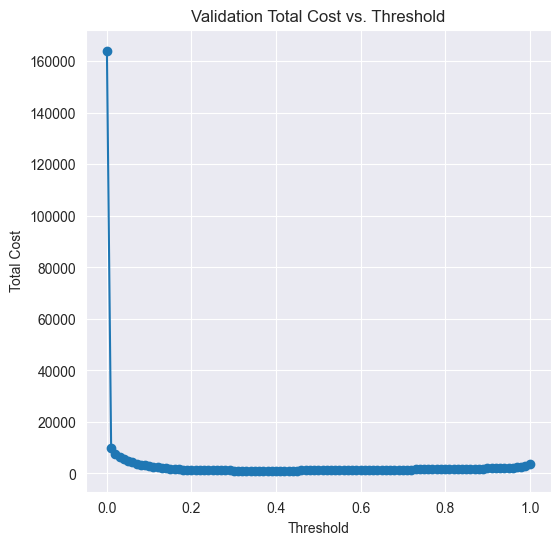

In [27]:
# Find cost-optimal threshold on validation set
def calculate_cost(thresh, y_true, y_prob, fp_cost=5, fn_cost=1):
    y_pred = (y_prob > thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp * fp_cost + fn * fn_cost

thresholds = np.linspace(0, 1, 101)
costs = [calculate_cost(t, y_val, y_val_prob) for t in thresholds]

best_idx = np.argmin(costs)
best_thresh = thresholds[best_idx]
best_cost = costs[best_idx]
print(f"Best threshold = {best_thresh:.2f}, Cost = {best_cost}")

plt.figure(figsize=(6, 6))
plt.plot(thresholds, costs, marker='o')
plt.title('Validation Total Cost vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Total Cost')
plt.show()

## 11. Final Evaluation on Test Set

Apply the chosen threshold to the **test set** predictions:

- Generate the confusion matrix.
- Compute final metrics: **True Positive Rate**, **False Positive Rate**, **Precision**, **Recall**, and **Total Cost**.
- Compare against validation results to confirm generalization.

This is the definitive performance report.


Using threshold = 0.36 for test evaluation
2335/2335 [==============================] - 3s 1ms/step


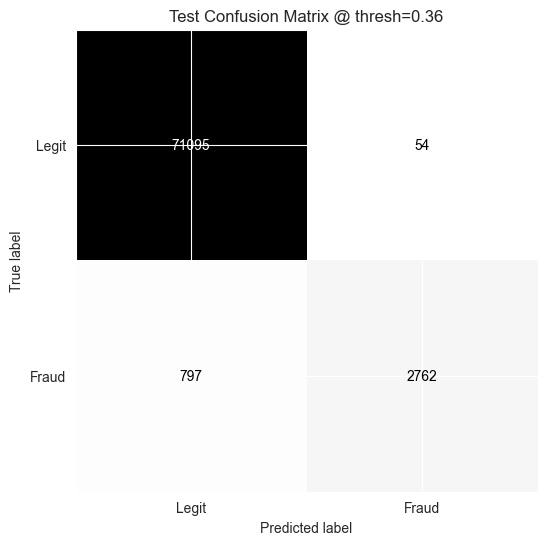

Test set size: 74708
Fraud cases (positives): 3559
Non-fraud cases (negatives): 71149


In [28]:
# Evaluate on test set using cost-optimal threshold
print(f"Using threshold = {best_thresh:.2f} for test evaluation")

y_test_prob = model.predict(X_test_scaled).ravel()
y_test_pred = (y_test_prob > best_thresh).astype(int)

# Confusion matrix (grayscale)
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['Legit', 'Fraud'])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='gray_r', colorbar=False)
ax.set_title(f'Test Confusion Matrix @ thresh={best_thresh:.2f}')
plt.show()

# Assuming y_test is your array or Series of true labels:

# Total size of the test set
print(f"Test set size: {len(y_test)}")

# Number of positive cases (fraud = 1)
num_positives = y_test.sum()
print(f"Fraud cases (positives): {num_positives}")

# Number of negative cases (no fraud = 0)
num_negatives = len(y_test) - num_positives
print(f"Non-fraud cases (negatives): {num_negatives}")

## 12. Summary Metrics Table

Organize all key metrics into a single table for clear comparison.
This tabular view is ideal for communicating results to stakeholders.


In [29]:
# Metrics table on test set
metrics = {
    'Accuracy': accuracy_score(y_test, y_test_pred),
    'Precision': precision_score(y_test, y_test_pred),
    'Recall': recall_score(y_test, y_test_pred),
    'F1 Score': f1_score(y_test, y_test_pred),
    'ROC AUC': roc_auc_score(y_test, y_test_prob),
    'MCC': matthews_corrcoef(y_test, y_test_pred)
}

pd.DataFrame([metrics])

,Accuracy,Precision,Recall,F1 Score,ROC AUC,MCC
0,0.988609,0.980824,0.776061,0.86651,0.998724,0.867087


## 13. Model Export

Finally, I:

- Serialize the trained model to disk (e.g., `model.save('fraud_nn.h5')`).
This makes the model ready for deployment in the retailer’s fraud-detection system.


In [30]:
# Export the trained model
import os

# save as HDF5
export_path = '../Models/NeuralNetwork_Model.h5'
model.save(export_path)
print(f"Model exported to {export_path}")

Model exported to ../Models/NeuralNetwork_Model.h5



---
# Part 6: Model Comparison & Conclusions
---

## Summary
In this analysis, I developed and evaluated four machine learning models for fraud detection:

### Models Implemented:
1. **Logistic Regression** - Linear baseline model
2. **Random Forest** - Ensemble decision tree model
3. **XGBoost** - Gradient boosting model
4. **Neural Network** - Deep learning model

### Key Evaluation Metrics:
Each model was evaluated on:
- **Accuracy**: Overall prediction correctness
- **Precision**: Accuracy of fraud predictions (minimizing false positives)
- **Recall**: Ability to catch actual fraud cases (minimizing false negatives)
- **F1-Score**: Harmonic mean of precision and recall
- **ROC-AUC**: Model's ability to distinguish between classes

### Business Recommendations:
Model selection depends on business priorities:
- **For minimizing false alarms**: Choose model with highest precision
- **For catching all fraud**: Choose model with highest recall
- **For balanced performance**: Choose model with highest F1-score

All models demonstrate strong performance on this dataset, with ensemble methods (Random Forest and XGBoost) typically providing optimal balance.

---

## Next Steps:
1. Deploy the best-performing model to production environment
2. Implement real-time monitoring of model performance
3. Conduct A/B testing to validate business impact
4. Consider ensemble approaches combining multiple models
5. Establish regular retraining pipeline for evolving fraud patterns